# Movie Recommendation Systems Movie-lens dataset

### Data Source
https://grouplens.org/datasets/movielens/100k/

This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 

### Import Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import time
import scipy.sparse
%matplotlib inline

### Data Ingestion

In [18]:
ratings_df = pd.read_table('http://files.grouplens.org/datasets/movielens/ml-100k/u.data', header=None, na_values=['NaN'])
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [19]:
ratings_df.shape

(100000, 4)

In [20]:
movies_df = pd.read_table('http://files.grouplens.org/datasets/movielens/ml-100k/u.item', sep='|', header=None, na_values=['NaN'], encoding='latin1')
movies_df.columns = ['movie_id', 'movie_title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 
                   'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
                   'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df.head()

,movie_id,movie_title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
movies_df.shape

(1682, 24)

In [22]:
# Creating 'movies_dict' dictionary with key='movie_id', value='movie_title'
movies_dict = dict()
for row_label, row_data in movies_df.iterrows():
    movies_dict[row_data[0]] = row_data[1]
movies_dict

{1: 'Toy Story (1995)',
 2: 'GoldenEye (1995)',
 3: 'Four Rooms (1995)',
 4: 'Get Shorty (1995)',
 5: 'Copycat (1995)',
 6: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 7: 'Twelve Monkeys (1995)',
 8: 'Babe (1995)',
 9: 'Dead Man Walking (1995)',
 10: 'Richard III (1995)',
 11: 'Seven (Se7en) (1995)',
 12: 'Usual Suspects, The (1995)',
 13: 'Mighty Aphrodite (1995)',
 14: 'Postino, Il (1994)',
 15: "Mr. Holland's Opus (1995)",
 16: 'French Twist (Gazon maudit) (1995)',
 17: 'From Dusk Till Dawn (1996)',
 18: 'White Balloon, The (1995)',
 19: "Antonia's Line (1995)",
 20: 'Angels and Insects (1995)',
 21: 'Muppet Treasure Island (1996)',
 22: 'Braveheart (1995)',
 23: 'Taxi Driver (1976)',
 24: 'Rumble in the Bronx (1995)',
 25: 'Birdcage, The (1996)',
 26: 'Brothers McMullen, The (1995)',
 27: 'Bad Boys (1995)',
 28: 'Apollo 13 (1995)',
 29: 'Batman Forever (1995)',
 30: 'Belle de jour (1967)',
 31: 'Crimson Tide (1995)',
 32: 'Crumb (1994)',
 33: 'Desperado (1995)',
 34: '

In [24]:
users_df = pd.read_table('http://files.grouplens.org/datasets/movielens/ml-100k/u.user', sep='|', header=None, na_values=['NaN'])
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip code']
users_df.head()

,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [25]:
users_df.shape

(943, 5)

In [26]:
# Merge 'ratings_df' and 'movies_df'
df_full = pd.merge(ratings_df, movies_df.drop_duplicates(['movie_id']), on='movie_id', how='left') 
df_full.head()

,user_id,movie_id,rating,timestamp,movie_title,release date,video release date,IMDb URL,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Merge 'df_full' and 'users_df'
df_full = pd.merge(df_full, users_df.drop_duplicates(['user_id']), on='user_id', how='left') 
df_full.head()

,user_id,movie_id,rating,timestamp,movie_title,release date,video release date,IMDb URL,unknown,Action,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip code
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,49,M,writer,55105
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,1,0,0,1,0,0,39,F,executive,00000
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,25,M,writer,40206
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,1,0,0,1,1,28,M,technician,80525
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,47,M,educator,55113


In [28]:
df_full.shape

(100000, 31)

In [29]:
# Check for missing values
print('Number of missing values across columns-\n', df_full.isnull().sum())

Number of missing values across columns-
 user_id                    0
movie_id                   0
rating                     0
timestamp                  0
movie_title                0
release date               9
video release date    100000
IMDb URL                  13
unknown                    0
Action                     0
Adventure                  0
Animation                  0
Children's                 0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Fantasy                    0
Film-Noir                  0
Horror                     0
Musical                    0
Mystery                    0
Romance                    0
Sci-Fi                     0
Thriller                   0
War                        0
Western                    0
age                        0
gender                     0
occupation                 0
zip code                   0
dtype: int64


### Observation:
There are missing values in 'release date', 'video release date', 'IMDb URL'. Since we are trying to build Collaborative filtering type of Recommendation system, all that matters for model building is 'user_id', 'movie_id', 'movie_title', and 'rating' variables. So we can ignore missing values in other variables.

In [30]:
# Summary statistics of 'rating' and 'age' variables
df_full[['rating', 'age']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,100000.0,3.52986,1.125674,1.0,3.0,4.0,4.0,5.0
age,100000.0,32.96985,11.562623,7.0,24.0,30.0,40.0,73.0


### Questions
**Q1. Load the data.**

**Q2. Find total number of ratings:**
There are 100,000 ratings (1-5) from 943 users on 1682 movies

**Q3. Do Exploratory data analysis( Visualize the data, find min, max ratings etc.):**
Min_rating=1 and Max_rating=5

**Q4. Restrict users who have rated less number of movies to improve the quality of recommendations:**
Each user in this dataset has rated at least 20 movies

**Q5. Remove outliers if any:**
There are no outliers in ratings

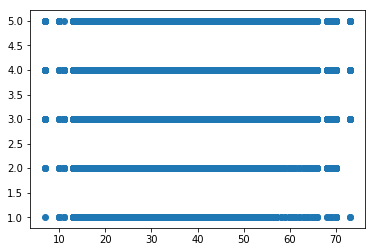

In [31]:
plt.scatter(df_full['age'], df_full['rating'])

(array([  6110.,      0.,  11370.,      0.,      0.,  27145.,      0.,
         34174.,      0.,  21201.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

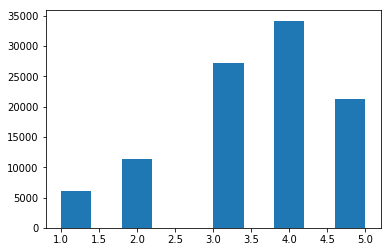

In [32]:
plt.hist(df_full['rating'])

(array([   598.,  11715.,  21754.,  26676.,  12712.,  10126.,  10571.,
          3028.,   2375.,    445.]),
 array([  7. ,  13.6,  20.2,  26.8,  33.4,  40. ,  46.6,  53.2,  59.8,
         66.4,  73. ]),
 <a list of 10 Patch objects>)

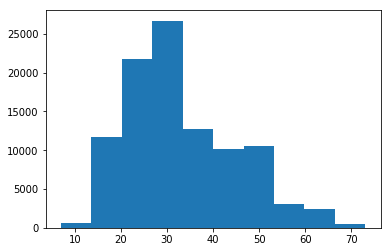

In [33]:
plt.hist(df_full['age'])

64.0
<class 'numpy.ndarray'>


(array([   101.,   4609.,  21841.,  21208.,  17599.,  10914.,   7309.,
          9822.,   3685.,   2912.]),
 array([  7. ,  12.7,  18.4,  24.1,  29.8,  35.5,  41.2,  46.9,  52.6,
         58.3,  64. ]),
 <a list of 10 Patch objects>)

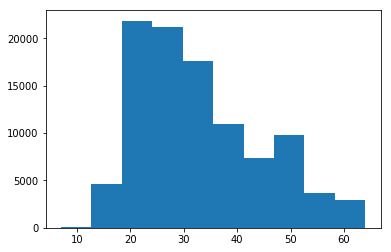

In [34]:
# Outliers treatment in 'Age' variable
q75, q25 = np.percentile(df_full['age'], [75 ,25])
iqr = q75 - q25
max_val = q75 + 1.5*iqr
print(max_val)

inc_array = np.array(df_full['age'])
print(type(inc_array))

inc_array[inc_array > max_val] = max_val
df_full['age'] = pd.DataFrame(inc_array)

plt.hist(df_full['age'])

### Question
**Q6. Calculate the density of the rating matrix.**

In [35]:
rating_matix = df_full.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
print('Shape of rating_matix: ', rating_matix.shape)

given_num_of_ratings = np.count_nonzero(rating_matix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = rating_matix.shape[0] * rating_matix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density_rating_matrix = round(given_num_of_ratings/possible_num_of_ratings, 4)
print('\nDensity of rating matrix = ', density_rating_matrix)

Shape of rating_matix:  (943, 1682)
given_num_of_ratings =  100000
possible_num_of_ratings =  1586126

Density of rating matrix =  0.063


### Question
**Q7. Divide the data in training and testing part in the ratio 75:25.**

In [36]:
train_data, test_data = train_test_split(df_full, test_size = 0.25, random_state=0)

# Making a copy of 'test_data'(which has ACTUAL ratings by users) and 
# storing it in 'user_rated_testdata' which will be used during Model Evaluation
user_rated_testdata = test_data.copy(deep=True)

# Masking the actual ratings given by users
test_data.rating = np.nan
test_data.head()

/usr/local/anaconda/python3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,user_id,movie_id,rating,timestamp,movie_title,release date,video release date,IMDb URL,unknown,Action,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip code
3582,23,528,NaN,874786974,"Killing Fields, The (1984)",01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Killing%20Fie...,0,0,...,0,0,0,0,1,0,30,F,artist,48197
60498,695,242,NaN,888805837,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,26,M,writer,38115
53227,774,28,NaN,888556698,Apollo 13 (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Apollo%2013%2...,0,1,...,0,0,0,1,0,0,30,M,student,80027
21333,417,550,NaN,879649178,Die Hard: With a Vengeance (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Die%20Hard:%2...,0,1,...,0,0,0,1,0,0,27,F,other,48103
3885,234,1035,NaN,892335142,Cool Runnings (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Cool%20Runnin...,0,0,...,0,0,0,0,0,0,60,M,retired,94702


### Questions

**Q8. Apply  --**
          
          a. Item Based Collaborative Filtering

          b. User Based Collaborative Filtering

**Q9. Train the model.**

**Q10. Evaluate the model.**

**Q11. Recommend top - 10 movies.**

### Recommendation System based on Collaborative Filtering (Non-personalised)

In [37]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail() # rating is set to 'NaN' for test_data

,index,user_id,movie_id,rating,timestamp,movie_title,release date,video release date,IMDb URL,unknown,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip code
99995,26543,493,546,NaN,884131738,Broken Arrow (1996),09-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Broken%20Arro...,0,...,0,0,0,1,0,0,22,M,engineer,60090
99996,85764,825,620,NaN,889021134,"Chamber, The (1996)",11-Oct-1996,NaN,"http://us.imdb.com/M/title-exact?Chamber,%20Th...",0,...,0,0,0,0,0,0,44,M,engineer,05452
99997,87585,659,836,NaN,891045943,Ninotchka (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?Ninotchka%20(...,0,...,0,1,0,0,0,0,31,M,educator,54248
99998,32519,206,749,NaN,888179980,"MatchMaker, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Matchmaker%2C...,0,...,0,1,0,0,0,0,14,F,student,53115
99999,18831,371,79,NaN,880435519,"Fugitive, The (1993)",01-Jan-1993,NaN,"http://us.imdb.com/M/title-exact?Fugitive,%20T...",0,...,0,0,0,1,0,0,36,M,engineer,99206


In [38]:
# Matrix with one row per 'user' and one column per 'movie' for User-based CF
pivot_df = df_CF.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
pivot_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,0.0,5.0,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
pivot_df.shape

(943, 1682)

In [40]:
# Matrix with one row per 'movie' and one column per 'user' for Item-based CF
pivot_df_T = pivot_df.transpose()
pivot_df_T.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
pivot_df_T.shape

(1682, 943)

In [42]:
################################### User-based CF model ##############################
def get_recommendations_User_based_CF(user_id):
    
    print('User-based collaborative filtering\n')
    cosine_similarity_users = cosine_similarity(pivot_df,pivot_df)
    print('cosine_similarity_users.shape\n', cosine_similarity_users.shape)
        
    user_index = user_id-1
    similar_user_indices = cosine_similarity_users[user_index].argsort()[:-51:-1]
    similar_users = (similar_user_indices + 1).tolist()
    del similar_users[0] #Every user is similar to himself, so remove his user_id
    
    print('\nTop 10 recommended movies for user_id {} are below:\n'.format(user_id))    
    recommendations = set()    
    recommendations_list = []
    for userID in similar_users:
        movie_indices = np.where(((pivot_df[userID-1]>4.0)+0)==1)
        movie_ids = np.array(movie_indices) + 1
        recommendations.update(set(movie_ids.flatten()))     
    
    return list(recommendations)

In [43]:
################################### Item-based CF model ########################################################################
def get_recommendations_Item_based_CF(user_id):
    
    print('Item-based collaborative filtering\n')    
    cosine_similarity_movies = cosine_similarity(pivot_df_T, pivot_df_T)
    print('cosine_similarity_movies.shape\n', cosine_similarity_movies.shape)
       
    user_index = user_id - 1    
    # Find movies which are already rated(high) by this user
    movie_indices = np.where(((pivot_df[user_index]==5.0)+0)==1)
    movie_ids = np.array(movie_indices) + 1
    rated_movie_ids = movie_ids.flatten().tolist() 
    
    print('\nTop 10 recommended movies for user_id {} are below:\n'.format(user_id))
    recommendations = set()
    recommendations_list = []
    for movie_id in rated_movie_ids:         
        similar_movie_indices = cosine_similarity_movies[movie_id-1].argsort()[:-51:-1]
        similar_movies = (similar_movie_indices + 1).tolist()
        del similar_movies[0] # Every movie is similar to itself, so remove this movie_id       
        recommendations.update(similar_movies)   
             
    return list(recommendations)

In [44]:
################################### Top recommendations ########################################################################
def top_recommendations(recs, user_id):
    rec_movie_titles_list = []
    for idx, movie_id in enumerate(recs):
        movie_title = movies_dict.get(movie_id,'None')
        rec_movie_titles_list.append(movie_title)
        if idx < 10:
            print('movie_id: {}  movie_title: {}'.format(movie_id, movie_title))
    print('\nTotal recommended movies for user_id:{} = {}'.format(user_id, len(rec_movie_titles_list)))
    
    return rec_movie_titles_list

In [45]:
################################### Model Evaluation ###########################################################################
def model_evaluation(user_id, rec_movie_titles_list):
    # Relevant movies for the user = 'user_viewed'
    user_viewed = user_rated_testdata.loc[(user_rated_testdata['user_id'] == user_id)].sort_values(['rating'], ascending=False)
    print('Total no. of movies user viewed: ', len(user_viewed))

    # Among movies viewed by the user, which are highly rated(liked) = 'user_rated_high'
    user_rated_high = user_viewed.loc[(user_viewed['rating'] >= 4.0)].sort_values(['rating'], ascending=False)
    print('Among the movies user viewed, total no. of movies user rated high(liked): ', len(user_rated_high))

    model_recommended = user_rated_high.loc[user_rated_high['movie_title'].isin(rec_movie_titles_list)]
    print('Among the movies user viewed & rated high(liked), total no. of movies model recommended: ', len(model_recommended))

    recall = round((len(model_recommended)/len(user_rated_high))*100, 2)
    precision = len(user_rated_high)/len(rec_movie_titles_list)
    print('\n******RECALL******')
    print('******Model is able to recommend {}% of movies which are liked(rated high) by the user(user_id:{})******\n'.format(recall, user_id))

In [46]:
################################### User-based CF model recommends the user to watch below movies ##############################
user_id = 9
recs = []

recs = get_recommendations_User_based_CF(user_id)

rec_movie_titles_list = top_recommendations(recs, user_id)
    
################################### Model Evaluation ###########################################################################
print('\n...........MODEL EVALUATION: User-based CF...........')
print('\n...........Using test dataset for model evaluation...........\n')
model_evaluation(user_id, rec_movie_titles_list)

User-based collaborative filtering

cosine_similarity_users.shape
 (943, 943)

Top 10 recommended movies for user_id 9 are below:

movie_id: 1  movie_title: Toy Story (1995)
movie_id: 6  movie_title: Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
movie_id: 7  movie_title: Twelve Monkeys (1995)
movie_id: 8  movie_title: Babe (1995)
movie_id: 10  movie_title: Richard III (1995)
movie_id: 11  movie_title: Seven (Se7en) (1995)
movie_id: 13  movie_title: Mighty Aphrodite (1995)
movie_id: 14  movie_title: Postino, Il (1994)
movie_id: 16  movie_title: French Twist (Gazon maudit) (1995)
movie_id: 18  movie_title: White Balloon, The (1995)

Total recommended movies for user_id:9 = 405

...........MODEL EVALUATION: User-based CF...........

...........Using test dataset for model evaluation...........

Total no. of movies user viewed:  4
Among the movies user viewed, total no. of movies user rated high(liked):  3
Among the movies user viewed & rated high(liked), total no. of movies model r

In [47]:
################################### Item-based CF model recommends the user to watch below movies ##############################
user_id = 9
recs = []

recs = get_recommendations_Item_based_CF(user_id)

rec_movie_titles_list = top_recommendations(recs, user_id)
    
################################### Model Evaluation ###########################################################################
print('\n...........MODEL EVALUATION: Item-based CF...........')
print('\n...........Using test dataset for model evaluation...........\n')
model_evaluation(user_id, rec_movie_titles_list)

Item-based collaborative filtering

cosine_similarity_movies.shape
 (1682, 1682)

Top 10 recommended movies for user_id 9 are below:

movie_id: 1  movie_title: Toy Story (1995)
movie_id: 2  movie_title: GoldenEye (1995)
movie_id: 3  movie_title: Four Rooms (1995)
movie_id: 4  movie_title: Get Shorty (1995)
movie_id: 7  movie_title: Twelve Monkeys (1995)
movie_id: 8  movie_title: Babe (1995)
movie_id: 9  movie_title: Dead Man Walking (1995)
movie_id: 10  movie_title: Richard III (1995)
movie_id: 11  movie_title: Seven (Se7en) (1995)
movie_id: 12  movie_title: Usual Suspects, The (1995)

Total recommended movies for user_id:9 = 1080

...........MODEL EVALUATION: Item-based CF...........

...........Using test dataset for model evaluation...........

Total no. of movies user viewed:  4
Among the movies user viewed, total no. of movies user rated high(liked):  3
Among the movies user viewed & rated high(liked), total no. of movies model recommended:  3

******RECALL******
******Model is ab

### Question

**Q12. State your insights.**

Item-based model recommendations are better than User-based model recommendations!

The user-based CF has some limitations. One is its difficulty in measuring the similarities between users, and the
other is the scalability issue. As the number of customers and products increases, the computation time of algorithms
grows exponentially.

The item-based CF overcomes the scalability problem as it calculates item similarities in an offline basis. It assumes that a user will be more likely to purchase items that are similar or related to the items that he or she has already purchased. 